In [10]:
from microstruktur.signal_models.cylinder_models import C4CylinderGaussianPhaseApproximation
from microstruktur.core.modeling_framework import MultiCompartmentMicrostructureModel
from microstruktur.signal_models import distribute_models
from microstruktur.signal_models.gaussian_models import G3Ball
from microstruktur.data import saved_acquisition_schemes, saved_data

In [7]:
data = saved_data.duval_cat_spinal_cord_2d()
scheme_duval = saved_acquisition_schemes.duval_cat_spinal_cord_2d_acquisition_scheme()

This data was used by Duval et al. 'Validation of quantitative MRI metrics using full slice histology with automatic axon segmentation', ISMRM 2016. Reference at http://indexsmart.mirasmart.com/ISMRM2016/PDFfiles/0928.html


In [8]:
scheme_duval.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1791
number of b0 measurements: 72
number of DWI shells: 9

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |199       |886             |0                        |3.0        |7.0       |36.152
1           |199       |5762            |0                        |3.0        |40.0      |57.288
2           |199       |9806            |0                        |8.0        |12.0      |46.152
3           |199       |12958           |0                        |8.0        |15.0      |46.152
4           |199       |18212           |0                        |8.0        |20.0      |46.152
5           |199       |23465           |0                        |8.0        |25.0      |47.288
6           |199       |28719           |0                        |8.0        |30.0      |52.288
7           |199       |33972           |0                        |8.0        |35.0      |57.288
8        

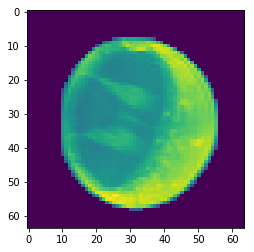

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data[:,:,0,0])

In [11]:
gamma_cylinder = distribute_models.DD1GammaDistributed(models=[C4CylinderGaussianPhaseApproximation()])

In [12]:
axcaliber = MultiCompartmentMicrostructureModel(scheme_duval, models=[G3Ball(), gamma_cylinder])
axcaliber.optimized_parameters['DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu'] = False
axcaliber.optimized_parameters['DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par'] = False

In [13]:
parameter_x0 = axcaliber.parameter_initial_guess_to_parameter_vector(
    DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu = [0, 0],
    DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par=1.7e-9)

DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu successfully set.
DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par successfully set.


In [14]:
# takes super long but at least the solution is good..
test = axcaliber.fit(data[20, 20],
                     parameter_initial_guess=parameter_x0,
                     use_parallel_processing=False,
                     solver='mix',
                     maxiter=1)

Starting fitting process
Fitting of 1 voxels complete in 86.0796298981 seconds.
Average of 86.0796298981 seconds per voxel.


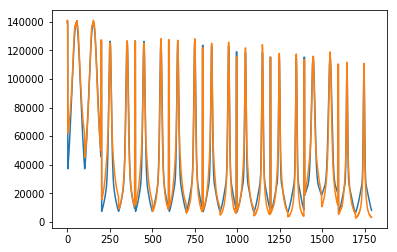

In [15]:
plt.plot(test.predict()[0])
plt.plot(data[20, 20, 0])

In [17]:
test.fitted_parameters

{'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par': array([[  1.70000025e-09]]),
 'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu': array([[  1.00000000e-06,   3.13924210e-07]]),
 'DD1GammaDistributed_1_DD1GammaDistribution_1_alpha': array([[ 30.]]),
 'DD1GammaDistributed_1_DD1GammaDistribution_1_beta': array([[  8.70319721e-08]]),
 'G3Ball_1_lambda_iso': array([[  7.08835651e-10]]),
 'partial_volume_0': array([[ 0.73671603]]),
 'partial_volume_1': array([[ 0.26328397]])}